In [ ]:
!pip install streamlit

In [ ]:
!pip install sentence-transformers

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np

nltk.download('punkt')
nltk.download('stopwords')

df_v1 = pd.read_excel('/content/ClientABC _ ATB Financial_Version1.xlsx')
df_final = pd.read_excel('/content/ClientABC _ ATB Financial_Final Version.xlsx')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def preprocess(df):
    cols = list(df)[:2]
    df[cols] = df[cols].ffill(axis=0)
    df = df.iloc[4:]
    df.columns = df.iloc[0]
    df = df.drop(df.index[0])
    df['Original ID'] = df['Original ID'].astype(str)
    return df

df_final=preprocess(df_final)
df_final.head()

4,Section Heading,Control Heading,Original ID,Question Text,Answer,Notes/Comment,identifier
5,Service Overview,Service Scope Question,3.3,What technology languages/platforms/stacks/com...,"""ClientABC"" database, Java, JavaScript, GO. Cl...",NaN,527c246f-dc2e-4873-a1d3-64a8ce1dda1b
6,Service Overview,Service Hosting,4.1,Is your service run from your own,B. The Cloud,NaN,909e4666-14a8-4a3f-8122-3f978c32caab
7,Service Overview,Service Hosting,4.2,Data Centre Location(s) (relative to services ...,"""ClientABC"" is available within the Amazon We...",NaN,9fd246fc-5ece-45e2-a0f8-9c34e6f3a8a9
8,Service Overview,Service Hosting,4.3,Which cloud providers do you rely on?,Our data centers are hosted on the cloud via A...,NaN,9e7ff978-612d-40d2-a18d-059389e820bb
9,Service Overview,Service Hosting,4.4,Have you researched your cloud providers best ...,Yes,NaN,a0aa89b4-8bd4-4b8d-a887-8d3d68da63c3


In [3]:
cols = list(df_v1)[:2]
df_v1[cols] = df_v1[cols].ffill(axis=0)
df_v1['Original ID'] = df_v1['Original ID'].astype(str)
df_v1.head()

,Section Heading,Control Heading,Original ID,Question Text,Answer,Notes/Comment,identifier
0,Service Overview,Service Scope Question,3.3,What technology languages/platforms/stacks/com...,"CentOS, ""ClientABC"" database, Java, JavaScript...",NaN,527c246f-dc2e-4873-a1d3-64a8ce1dda1b
1,Service Overview,Service Hosting,4.1,Is your service run from your own,B. The Cloud,NaN,909e4666-14a8-4a3f-8122-3f978c32caab
2,Service Overview,Service Hosting,4.2,Data Centre Location(s) (relative to services ...,"""ClientABC"" is available within the Amazon We...",NaN,9fd246fc-5ece-45e2-a0f8-9c34e6f3a8a9
3,Service Overview,Service Hosting,4.3,Which cloud providers do you rely on?,Our data centers are hosted on the cloud via A...,NaN,9e7ff978-612d-40d2-a18d-059389e820bb
4,Service Overview,Service Hosting,4.4,Have you researched your cloud providers best ...,Yes,NaN,a0aa89b4-8bd4-4b8d-a887-8d3d68da63c3


In [4]:
def create_wordcloud(text, title):
    text = ' '.join([str(t) for t in text if pd.notna(t)])
    if text.strip():
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title)
        plt.show()

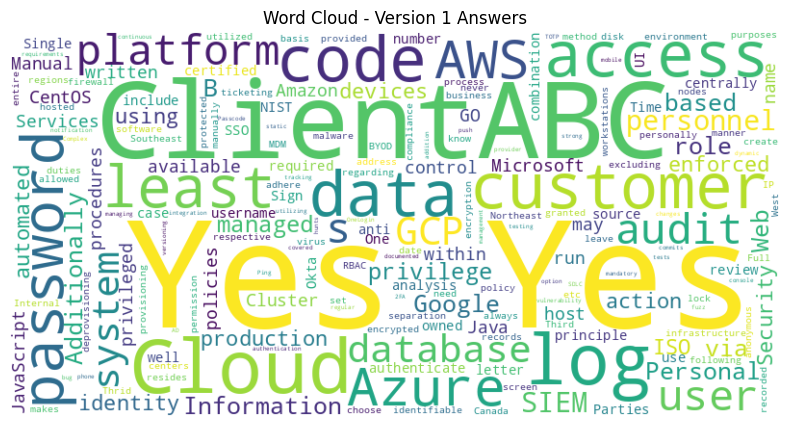

In [5]:
create_wordcloud(df_v1['Answer'], 'Word Cloud - Version 1 Answers')

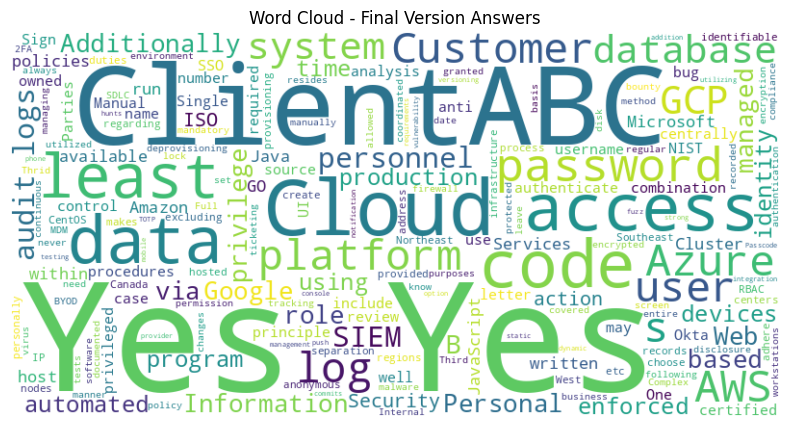

In [6]:
create_wordcloud(df_final['Answer'], 'Word Cloud - Final Version Answers')

In [7]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

model = SentenceTransformer('all-MiniLM-L6-v2')

def similarity_ratio(a, b):
    if pd.isna(a) and pd.isna(b):
        return 1.0
    elif pd.isna(a) or pd.isna(b):
        return 0.0

    a_enc = model.encode([str(a)])
    b_enc = model.encode([str(b)])

    similarity = cosine_similarity(a_enc, b_enc)[0][0]

    return similarity

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [8]:
def calculate_similarity_score(df1, df2, similarity_func):
    merged_df = df1.merge(df2, on='Original ID', suffixes=('_v1', '_final'))
    merged_df['Similarity_Score'] = merged_df.apply(lambda row: similarity_func(row['Answer_v1'], row['Answer_final']), axis=1)
    return merged_df[['Original ID', 'Answer_v1', 'Answer_final', 'Similarity_Score']]

merged_df = calculate_similarity_score(df_v1, df_final, similarity_ratio)

merged_df.head()

,Original ID,Answer_v1,Answer_final,Similarity_Score
0,3.3,"CentOS, ""ClientABC"" database, Java, JavaScript...","""ClientABC"" database, Java, JavaScript, GO. Cl...",0.981169
1,4.1,B. The Cloud,B. The Cloud,1.000000
2,4.2,"""ClientABC"" is available within the Amazon We...","""ClientABC"" is available within the Amazon We...",1.000000
3,4.3,Our data centers are hosted on the cloud via A...,Our data centers are hosted on the cloud via A...,1.000000
4,4.4,Yes,Yes,1.000000


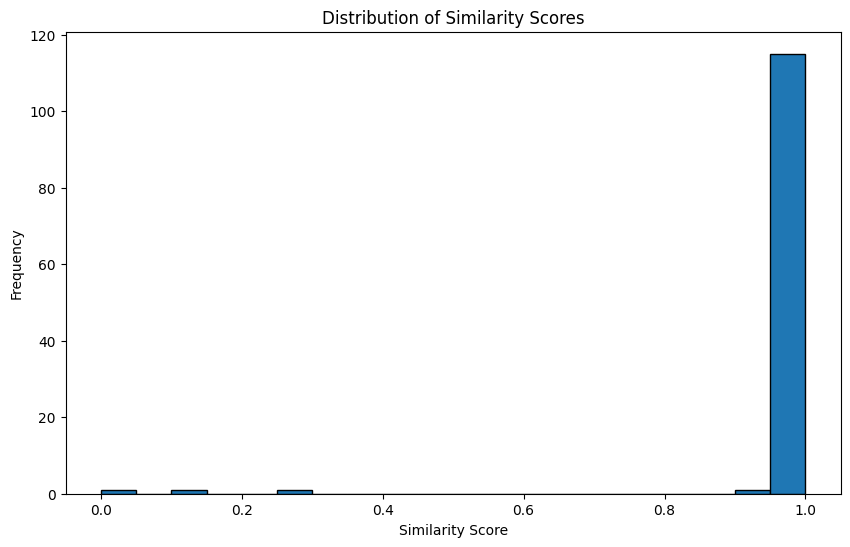

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(merged_df['Similarity_Score'], bins=20, edgecolor='black')
plt.title('Distribution of Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.show()


In [10]:
from scipy import stats

def explain_similarity_histogram(similarity_scores):
    mean_score = np.mean(similarity_scores)
    median_score = np.median(similarity_scores)
    std_dev = np.std(similarity_scores)

    percentiles = np.percentile(similarity_scores, [25, 50, 75])

    skewness = stats.skew(similarity_scores)
    kurtosis = stats.kurtosis(similarity_scores)

    explanation = f"""
    Explanation of the Similarity Scores Distribution:

       - The mean similarity score is {mean_score:.2f}.
       - The median similarity score is {median_score:.2f}.

       - The standard deviation of the scores is {std_dev:.2f}.

       - Skewness: {skewness:.2f} ({'positively' if skewness > 0 else 'negatively'} skewed)
         {' This suggests more scores are concentrated on the left side of the distribution.' if skewness > 0 else ' This suggests more scores are concentrated on the right side of the distribution.'}
       - Kurtosis: {kurtosis:.2f} ({'more' if kurtosis > 0 else 'less'} peaked than a normal distribution)
         {' This indicates more extreme values than a normal distribution.' if kurtosis > 0 else ' This indicates fewer extreme values than a normal distribution.'}

       - {'Most answers show high similarity between versions, suggesting minor changes overall.' if mean_score > 0.7 else 'Many answers show significant differences between versions, indicating more changes.'}
       - {'There is a wide range of similarity scores, indicating varied levels of changes across different questions.' if std_dev > 0.3 else 'The similarity scores are fairly consistent across questions, suggesting uniform levels of changes.'}
       - {'Some questions may have been completely rewritten or newly added, as indicated by very low similarity scores.' if np.min(similarity_scores) < 0.1 else 'The majority maintain similarity to the Version 1 document'}
    """

    print(explanation)

explain_similarity_histogram(merged_df['Similarity_Score'])


    Explanation of the Similarity Scores Distribution:

       - The mean similarity score is 0.98.
       - The median similarity score is 1.00.

       - The standard deviation of the scores is 0.14.

       - Skewness: -6.21 (negatively skewed)
          This suggests more scores are concentrated on the right side of the distribution.
       - Kurtosis: 37.37 (more peaked than a normal distribution)
          This indicates more extreme values than a normal distribution.

       - Most answers show high similarity between versions, suggesting minor changes overall.
       - The similarity scores are fairly consistent across questions, suggesting uniform levels of changes.
       - Some questions may have been completely rewritten or newly added, as indicated by very low similarity scores.
    


In [11]:
def categorize_similarity(score):
    if score < 0.3:
        return 'Completely Different'
    elif score < 0.7:
        return 'Somewhat Similar'
    else:
        return 'Very Similar'

merged_df['Similarity_Category'] = merged_df['Similarity_Score'].apply(categorize_similarity)

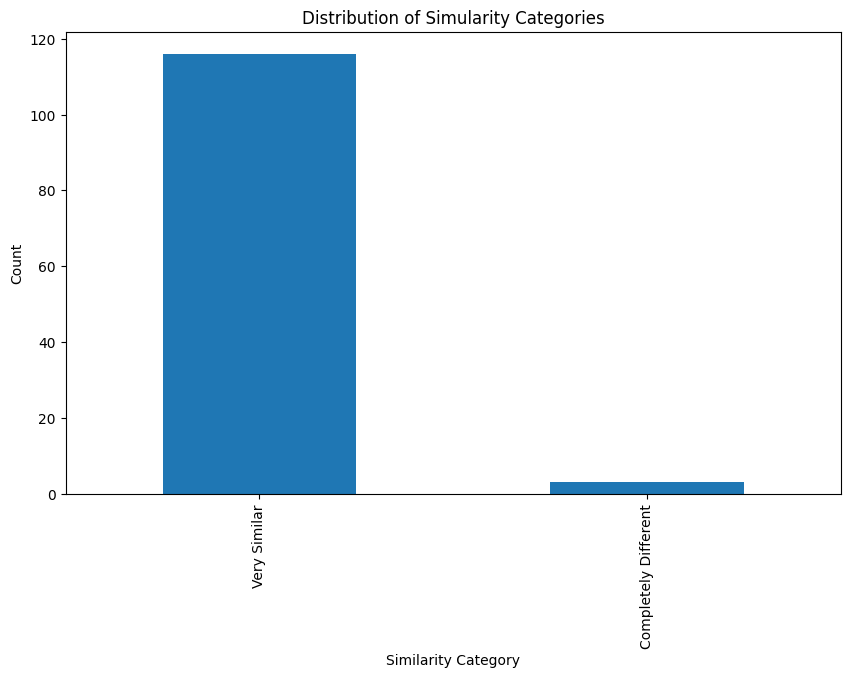

In [12]:
plt.figure(figsize=(10, 6))
merged_df['Similarity_Category'].value_counts().plot(kind='bar')
plt.title('Distribution of Simularity Categories')
plt.xlabel('Similarity Category')
plt.ylabel('Count')
plt.show()

In [13]:
def analyze_change_type(a, b):
    if pd.isna(a) and pd.isna(b):
        return 'Both Empty'
    elif pd.isna(a) and not pd.isna(b):
        return 'Added in Final'
    elif not pd.isna(a) and pd.isna(b):
        return 'Removed in Final'

    a_words = set(word_tokenize(str(a).lower()))
    b_words = set(word_tokenize(str(b).lower()))
    common_words = a_words.intersection(b_words)

    if len(common_words) / max(len(a_words), len(b_words)) > 0.9:
        return 'Mainly Format/Grammar'
    else:
        return 'Content Change'

In [14]:
df_v1['Change_Type'] = df_v1.apply(
    lambda row: analyze_change_type(
        row['Answer'],
        df_final[df_final['Original ID'] == row['Original ID']]['Answer'].values[0]
    ) if not df_final[df_final['Original ID'] == row['Original ID']].empty else 'ID not found',
    axis=1
)

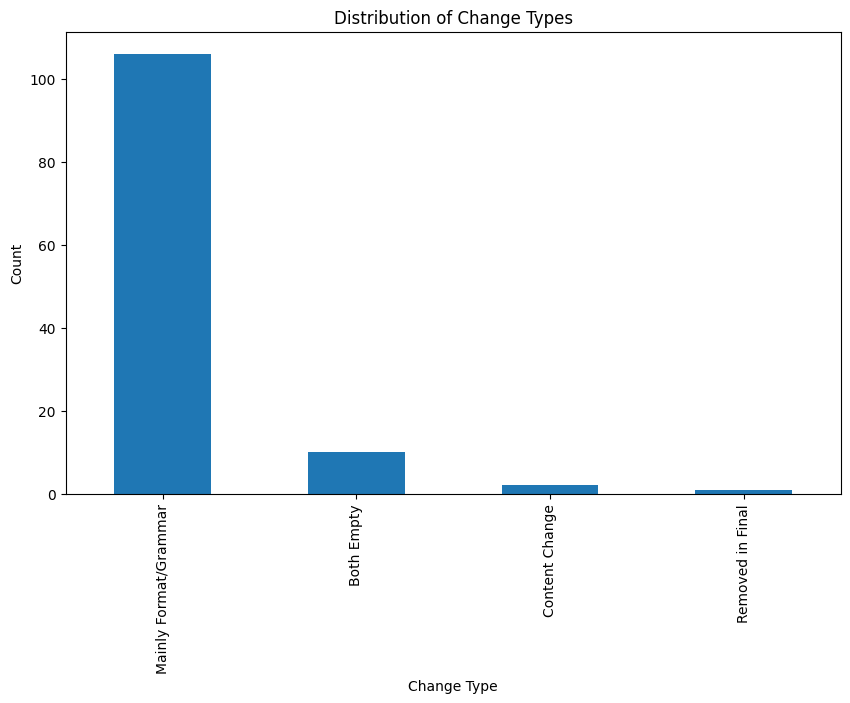

In [15]:
plt.figure(figsize=(10, 6))
df_v1['Change_Type'].value_counts().plot(kind='bar')
plt.title('Distribution of Change Types')
plt.xlabel('Change Type')
plt.ylabel('Count')
plt.show()


In [16]:
(df_v1[df_v1['Change_Type'] == 'Both Empty'][['Original ID', 'Question Text', 'Answer']]).head(10)

,Original ID,Question Text,Answer
7,5.1,Most recent Application Code Review or Penetra...,NaN
9,5.3,Information Security Policies and Procedures,NaN
10,5.4,Data Flow Diagram,NaN
11,5.5,Any other Documents supporting your responses ...,NaN
12,5.6,"PCI, SOC2 type II or ISO27001 certification re...",NaN
13,5.7,Other Independent Audit report (please provide...,NaN
15,6.2,Please upload your data classification matrix ...,NaN
20,8.4,How is the anonymized data used within your or...,NaN
112,39.2,Please provide a copy of the most recent report.,NaN
114,40.2,Please provide a copy of the most recent certi...,NaN


In [17]:
print("Summary Statistics:")
print(f"Total questions: {len(df_v1)}")
print(f"Average similarity score: {merged_df['Similarity_Score'].mean():.2f}")
print("\nChange Similarity Distribution:")
print(merged_df['Similarity_Category'].value_counts(normalize=True))
print("\nChange Type Distribution:")
print(df_v1['Change_Type'].value_counts(normalize=True))

Summary Statistics:
Total questions: 119
Average similarity score: 0.98

Change Similarity Distribution:
Similarity_Category
Very Similar            0.97479
Completely Different    0.02521
Name: proportion, dtype: float64

Change Type Distribution:
Change_Type
Mainly Format/Grammar    0.890756
Both Empty               0.084034
Content Change           0.016807
Removed in Final         0.008403
Name: proportion, dtype: float64


In [18]:
significant_changes = df_v1[merged_df['Similarity_Score'] < 0.5]
print("\nQuestions with Significant Changes:")
for idx, row in significant_changes.iterrows():
    print(f"\nQuestion {idx + 1}:")
    print(f"Version 1: {row['Answer']}")
    print(f"Final Version: {df_final.loc[idx, 'Answer']}")


Questions with Significant Changes:

Question 19:
Version 1: Yes
Final Version: nan

Question 59:
Version 1: Yes
Final Version: A. Internal; B. Thrid Parties

Question 70:
Version 1: Yes
Final Version: No


In [19]:
!pip freeze > requirements.txt